# Predicting Category from Job Postings

In this workshop, we'll try a classification task involving text.

This task is to predict job categories from Google Job postings.

## Dataset
https://www.kaggle.com/niyamatalmass/google-job-skills/version/1

(Requires free Kaggle account)

## Setup

We'll be using spaCy, a popular library for natural language processing (https://spacy.io/) to do some basic text processing.

Run this from your conda environment:

```
conda install -y spacy
python -m spacy download en_core_web_sm
```

The first command installs spaCy. 

The second command downloads spaCy's English pre-trained model. Language models require separate downloads because they are big files and are different for each language you need.

scikit-learn also has some NLP support, but only English and not as powerful as spaCy.

## Data Exploration

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [64]:
df = pd.read_csv('/tmp/google-jobs/job_skills.csv')
df.Category.unique()

array(['Program Management', 'Manufacturing & Supply Chain',
       'Technical Solutions', 'Developer Relations',
       'Hardware Engineering', 'Partnerships',
       'Product & Customer Support', 'Software Engineering',
       'Data Center & Network', 'Business Strategy', 'Technical Writing',
       'Technical Infrastructure', 'IT & Data Management',
       'Marketing & Communications', 'Network Engineering',
       'Sales & Account Management', 'Sales Operations', 'Finance',
       'Legal & Government Relations', 'Administrative',
       'User Experience & Design', 'People Operations',
       'Real Estate & Workplace Services'], dtype=object)

In [65]:
df.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


### Check for NaN

In [66]:
df.isnull().values.any()

True

In [67]:
# there are NA values, drop them and then check again
df.dropna(inplace=True)
df.isnull().values.any()

False

### Merge some smaller classes

In [60]:
df.groupby(['Category']).size()

Category
Administrative                       40
Business Strategy                    98
Data Center & Network                 2
Developer Relations                   5
Finance                             115
Hardware Engineering                 22
IT & Data Management                  5
Legal & Government Relations         46
Manufacturing & Supply Chain         16
Marketing & Communications          165
Network Engineering                   6
Partnerships                         59
People Operations                    86
Product & Customer Support           50
Program Management                   72
Real Estate & Workplace Services     25
Sales & Account Management          168
Sales Operations                     31
Software Engineering                 24
Technical Infrastructure             11
Technical Solutions                 100
Technical Writing                     5
User Experience & Design             84
dtype: int64

In [61]:
# Combine a few categories that are smaller, e.g.
#   Data Center & Network, Network Engineering, IT & Data Management => IT & Data Management

df.loc[df.Category == 'Data Center & Network', 'Category'] = 'IT & Data Management'
df.loc[df.Category == 'Network Engineering', 'Category'] = 'IT & Data Management'
df.groupby(['Category']).size()

Category
Administrative                       40
Business Strategy                    98
Developer Relations                   5
Finance                             115
Hardware Engineering                 22
IT & Data Management                 13
Legal & Government Relations         46
Manufacturing & Supply Chain         16
Marketing & Communications          165
Partnerships                         59
People Operations                    86
Product & Customer Support           50
Program Management                   72
Real Estate & Workplace Services     25
Sales & Account Management          168
Sales Operations                     31
Software Engineering                 24
Technical Infrastructure             11
Technical Solutions                 100
Technical Writing                     5
User Experience & Design             84
dtype: int64

## Data Transformation

### Label encoding

Label encode the 'Category' column into numbers to form our output (Y).

In [104]:
encoder = LabelEncoder()

category_enc = encoder.fit_transform(df.Category)

df['y'] = category_enc
df.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,y
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...,14
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin...",8
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,20
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,...",3
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...,14


### Text to Vectors (a little taste of NLP)

In order to train a model, we'll need convert the "Responsibilities" column from text into vectors.

Let's try:
1. Lemmatizing the words using English language rules (e.g. features -> feature)
2. Removing stop words such as "a", "the", "to" that don't contribute much semantic meaning.
3. Computing the TF-IDF (Term Frequency - Inverse Document Frequency) for each word (term) in the Responsibility column. This gives us a real number representation of each word.
4. Treat each word as a separate feature in X. (This is where lemmatizing and removing stop words will keep the number of features small.)

#### Notes:
The downside to this approach (while relatively simple), is that we end up with lots of features. However, this should be okay for a small corpus (couple thousand short sentences on a specific domain).

To handle larger corpora (hundreds of MBs to GBs), a more scalable approach is to train word vectors, which are slightly more involving (need hyperparameter guessing^H^H tuning). Word vectors will be overkill for this task, but an option once we've covered them in class.

In [59]:
# Example text we want to convert
df.Responsibilities[0]

'Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expectations and rationale on deliverables for stakeholders and program contributors.\nProvide program performance feedback to teams in Product, Engineering, Sales, and Marketing (among others) to enable efficient cross-team operations.'

In [93]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en_core_web_sm')
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

# transformation function to use in pd.DataFrame.apply()
def tokenize_text(text):
    """Tokenizes the text by lemmatizing and removing stop words
    Args:
        text - the input text
    Returns:
        a list of tokens
    """
    # process the text
    doc = nlp(text)
    
    # https://spacy.io/api/token
    lemmas = [lemmatizer(token.text, token.pos_) for token in doc
              if not token.is_stop and token.is_alpha]

    # create a string
    return ' '.join([item for sublist in lemmas for item in sublist])
            
# Test
tokenize_text(df.Responsibilities[0])

'shape shepherd ship technical program design support work cloud customer engineers solutions architects measure report key metric tie program identify need change course cancel scale program regional global platform communicate statu identify obstacle path resolution stakeholder include senior role transparent regular professional timely manner establish expectation rationale deliverable stakeholder program contributor provide program performance feedback team product engineering sale marketing enable efficient cros team operation'

In [99]:
# Tokenize the column
df_tokenized = df.Responsibilities.apply(tokenize_text)
df_tokenized.head()

0    shape shepherd ship technical program design s...
1    drive cros functional activity supply chain ov...
2    collect analyze datum draw insight identify st...
3    work android ios web engineer build exciting n...
4    plan requirement internal customer provide por...
Name: Responsibilities, dtype: object

### TF-IDF

See text.ipynb under 'Frequency Analysis' for formulas.

- We'll perform frequency analysis on each term (e.g. 'shape' across all documents).
- Each Job Responsibility is treated as a "document".
- Frequency analysis will compute a number indicating how important that word is in the corpus.
- Rare words that have high importance are accorded higher weight (e.g. datum or shepherd).

http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [101]:
# Apply the vectorizer on all tokenized Responsibility rows

vectorizer = TfidfVectorizer(lowercase=False, decode_error='ignore')

X = vectorizer.fit_transform(df_tokenized)

# convert sparse matrix to dense matrix
X_dense = X.todense()

print(X_dense.shape)

# print the features
print(vectorizer.get_feature_names())

(1235, 2972)
['ability', 'able', 'abreast', 'abroad', 'absence', 'abstraction', 'abuse', 'academia', 'accelerate', 'accelerated', 'acceleration', 'accelerator', 'accept', 'acceptance', 'acces', 'accessibility', 'accessory', 'accommodate', 'accommodation', 'accomplish', 'accomplishment', 'accord', 'accordance', 'accordingly', 'account', 'accountability', 'accountable', 'accounting', 'accounts', 'accrual', 'accuracy', 'accurate', 'accurately', 'achieve', 'achievement', 'achiv', 'achive', 'acquire', 'acquisition', 'act', 'action', 'actionable', 'activate', 'activation', 'active', 'actively', 'activity', 'actual', 'actualize', 'acuman', 'ad', 'adapt', 'add', 'addition', 'additional', 'additionally', 'additive', 'addres', 'address', 'addressable', 'adequate', 'adhere', 'adherence', 'adheres', 'adhoc', 'adjust', 'adjustment', 'administer', 'administration', 'administrative', 'admission', 'admob', 'adopt', 'adoption', 'ads', 'adsense', 'advance', 'advanced', 'advancement', 'advantage', 'adver

## Visualize

t-SNE (t-Distributed Stochastic Neighbour Embedding) is more suited for sparse features than PCA.

Text features are "sparse" because not all the same words always appear.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_dense)

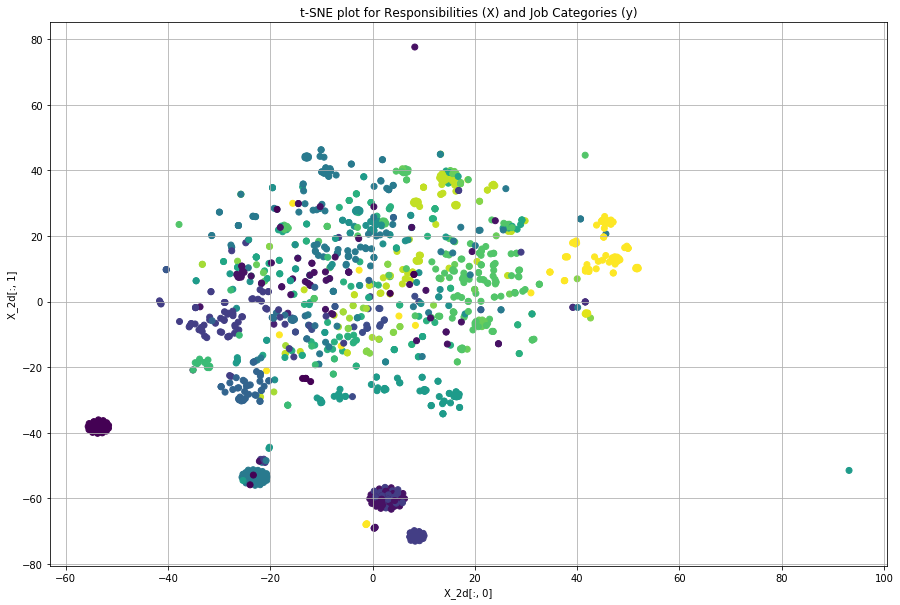

In [124]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_2d[:, 0], X_2d[:, 1], c=df.y)

ax.set(title='t-SNE plot for Responsibilities (X) and Job Categories (y)',
       xlabel='X_2d[:, 0]', ylabel='X_2d[:, 1]')
ax.grid()
plt.show()

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dense, df.y, random_state=42)

In [143]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier # just for kicks

from sklearn.metrics import classification_report

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(random_state=42, tol=1e-8, max_iter=1000),
    GaussianNB(),
    SVC(kernel='poly', degree=5, random_state=42),
    KNeighborsClassifier(),
    MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
]

for clf in classifiers:
    print(type(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))

<class 'sklearn.dummy.DummyClassifier'>
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.04      0.03      0.03        31
          3       0.00      0.00      0.00         1
          4       0.21      0.27      0.23        30
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         7
          8       0.00      0.00      0.00         6
          9       0.10      0.10      0.10        42
         11       0.07      0.08      0.07        13
         12       0.00      0.00      0.00        19
         13       0.10      0.05      0.07        20
         14       0.06      0.06      0.06        17
         15       0.00      0.00      0.00         6
         16       0.15      0.15      0.15        48
         17       0.00      0.00      0.00         7
         18       0.00      0.00      0.00         4
     

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.50      0.67         6
          1       0.59      0.77      0.67        31
          3       1.00      1.00      1.00         1
          4       0.88      0.50      0.64        30
          5       0.00      0.00      0.00         2
          6       1.00      0.25      0.40         4
          7       1.00      0.86      0.92         7
          8       0.60      1.00      0.75         6
          9       0.71      0.93      0.80        42
         11       0.53      0.62      0.57        13
         12       0.89      0.89      0.89        19
         13       1.00      0.50      0.67        20
         14       0.80      0.47      0.59        17
         15       0.80      0.67      0.73         6
         16       0.85      0.83      0.84        48
         17       0.44      0.57      0.50         7
         18       0.27      1.00      0.42         4
         19       0.00      0.00      0.00   

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.50      0.67         6
          1       0.53      0.68      0.59        31
          3       1.00      1.00      1.00         1
          4       0.85      0.77      0.81        30
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         4
          7       0.60      0.86      0.71         7
          8       0.86      1.00      0.92         6
          9       0.70      0.74      0.72        42
         10       0.00      0.00      0.00         0
         11       0.39      0.54      0.45        13
         12       1.00      0.84      0.91        19
         13       0.44      0.20      0.28        20
         14       0.50      0.35      0.41        17
         15       0.67      0.67      0.67         6
         16       0.67      0.75      0.71        48
         17       0.40      0.57      0.47         7
         18       0.80      1.00      0.89   

## Learning Curve

Example of learning curve.

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizati

train_size mean_train_score mean_val_score
60 0.9888888888888889 0.4341765653944691
197 0.9898477157360407 0.6031442820215255
334 0.9870259481037924 0.6699346812259929
471 0.97310686482661 0.698042004450324
608 0.9566885964912282 0.7127501571697481


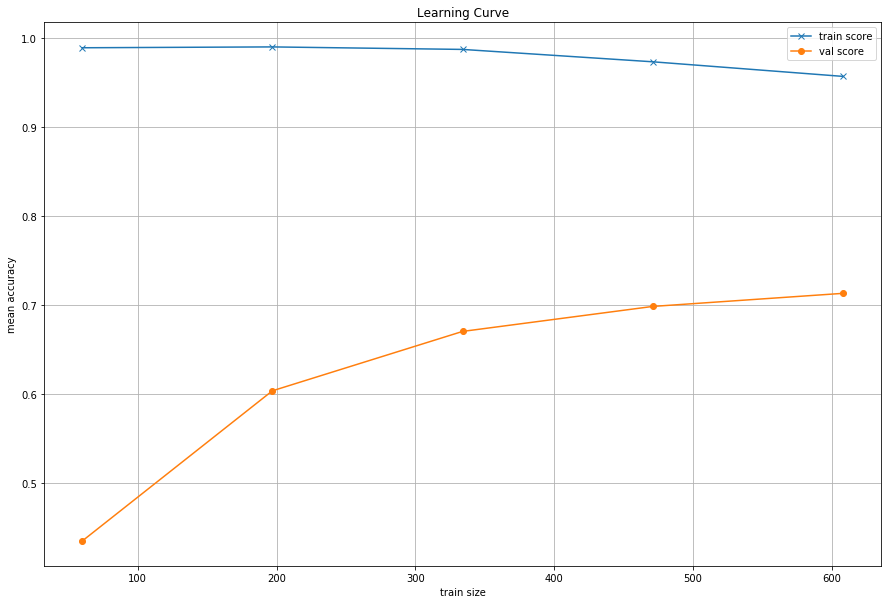

In [163]:
from sklearn.model_selection import learning_curve

clf = MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
train_sizes, train_score, val_score = learning_curve(clf, X_train, y_train)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)

print('train_size', 'mean_train_score', 'mean_val_score')
for train_size, t, m in zip(train_sizes, train_mean, val_mean):
    print(train_size, t, m)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train_sizes, train_mean, label='train score', marker='x')
ax.plot(train_sizes, val_mean, label='val score', marker='o')

ax.set(xlabel='train size', ylabel='mean accuracy', title='Learning Curve')
ax.grid()
ax.legend()
plt.show()    

## Predictions

Let's perform some predictions with real job postings.

1. https://careers.google.com/jobs/
2. Pick a posting, copy the Job Responsibilities
3. Transform the input by tokenizing and then using the TfIdfVectorizer
4. Get the prediction

In [152]:
# https://careers.google.com/jobs/#!t=jo&jid=/google/migrations-architect-google-cloud-singapore-3974200108&

test = """Work closely with strategic clients, both engineering and non-technical, to lead migration projects and customer implementations on Google Cloud.
Coordinate with a diverse team of stakeholders and supporting Googlers, including Sales, Solutions Engineers and the Professional Services organization.
Build core migration tooling across all Google Cloud Platform products and relevant third-party software.
Establish and drive planning and execution steps towards production deployments.
Write/develop deployment templates, orchestration scripting, database replication configurations, CI/CD pipeline assemblies, etc."""

token_string = tokenize_text(test)
test_tfidf = vectorizer.transform([token_string]).todense()

for clf in classifiers:
    print(clf) # prints the classifier information
    pred = clf.predict(test_tfidf)
    print(encoder.inverse_transform(pred))
    print()

DummyClassifier(constant=None, random_state=42, strategy='stratified')
['Business Strategy']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
['Technical Solutions']

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=1e-08, verbose=0, warm_start=False)
['Technical Solutions']

GaussianNB(priors=None)
['Technical Solutions']

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=Fals

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous